# Cart-Pole with Walls, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
%load_ext autoreload
%autoreload 2
#%pylab notebook

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController, HybridPolicyLibrary
from pympc.geometry import Polytope

numeric parameters

In [3]:
mc = 1.
mp = 1.
l = 1.
d = 1.
k = 100.
g = 10.
t_s = .05

dynamics

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.0 (contact with left wall)
A_0 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B_0 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_0 = np.array([
    [0.],
    [0.],
    [0.],
    [(d*k)/(l*mp)]
    ])
S_0 = ds.DTAffineSystem.from_continuous(A_0, B_0, c_0, t_s, method)

# dynamics n.1 (free)
A_1 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [0., g*(mc+mp)/(l*mc), 0., 0.]
    ])
B_1 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_1 = np.zeros((4,1))
S_1 = ds.DTAffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2 (contact with right wall)
A_2 = np.array([
    [0., 0., 1., 0.],
    [0., 0., 0., 1.],
    [0., (g*mp)/mc, 0., 0.],
    [k/(l*mp), (g*mp**2 + g*mc*mp - k*l*mc)/(l*mc*mp), 0., 0.]
    ])
B_2 = np.array([
    [0.],
    [0.],
    [1./mc],
    [1./(l*mc)]
    ])
c_2 = np.array([
    [0.],
    [0.],
    [0.],
    [-(d*k)/(l*mp)]
    ])
S_2 = ds.DTAffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_0, S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state bounds
x_max = np.array([[1.5*d],[np.pi/6.],[7.],[5.]])
x_min = -x_max

# state domain n.1
lhs_0 = np.array([[1., -l, 0., 0.]])
rhs_0 = np.array([[-d]])
X_0 = Polytope.from_bounds(x_min, x_max)
X_0.add_facets(lhs_0, rhs_0)
X_0.assemble()

# state domain n.2
lhs_1 = np.array([[-1., l, 0., 0.], [1., -l, 0., 0.]])
rhs_1 = np.array([[d], [d]])
X_1 = Polytope.from_bounds(x_min, x_max)
X_1.add_facets(lhs_1, rhs_1)
X_1.assemble()

# state domain n.3
lhs_2 = np.array([[-1., l, 0., 0.]])
rhs_2 = np.array([[-d]])
X_2 = Polytope.from_bounds(x_min, x_max)
X_2.add_facets(lhs_2, rhs_2)
X_2.assemble()

# list of state domains
X = [X_0, X_1, X_2]

# input domain
u_max = np.array([[100.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*3

We can now define the PWA system.

In [6]:
pwa_sys = ds.DTPWASystem.from_orthogonal_domains(S, X, U)

In [7]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[1].A, S[1].B, Q, R)
#X_N = ds.moas_closed_loop(S[1].A, S[1].B, K, X[1], U[1])

# save
#np.save('moas_cart_pole', X_N)

# load
X_N = np.load('moas_cart_pole.npy').item()

#x_max_N = np.ones((4,1))*.13
#x_min_N = - x_max_N
#X_N = Polytope.from_bounds(x_min_N, x_max_N)
#X_N.assemble()
#print 'check this', X_N.included_in(moas)

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

We can now simulate the closed-loop dynamics starting from the initial state $x_0$.

In [8]:
N_sim = 2
x_0 = np.array([[0.],[0.],[2.5],[0.]])
u = []
x = [x_0]
u_ws = None
x_ws = None
ss_ws = None
terminal_mode = 1
for k in range(N_sim):
    print k,
    u_k, x_k, ss_k = controller.feedforward(x[k], u_ws, x_ws, ss_ws)[0:3]
    x_next = pwa_sys.simulate(x[k], [u_k[0]])[0][1]
    u.append(u_k[0])
    x.append(x_next)
    u_ws = u_k[1:] + [K.dot(x_k[-1])]
    x_ws = x_k[1:] + [pwa_sys.simulate(x_k[-1], [u_ws[-1]])[0][1]]
    ss_ws = ss_k[1:] + (terminal_mode,)

0 1


We can use the plot functions to visualize the time evolution of the system.

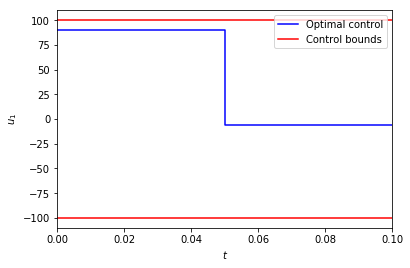

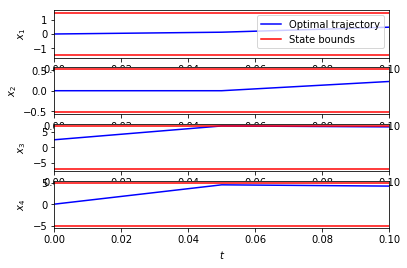

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min, x_max))
plt.show()

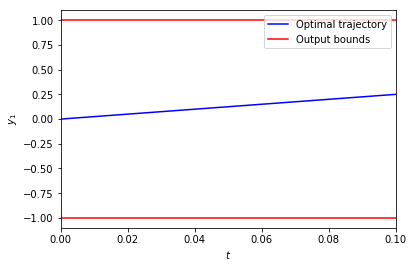

In [10]:
C = np.array([[1., -l, 0., 0.]])
y_max = np.array([[d]])
y_min = -y_max
mpc_plt.output_trajectory(C, x, t_s, (y_min, y_max))
plt.show()

In [26]:
# initialization of the library

policy = HybridPolicyLibrary(controller)

# coverage

n_samples = 1000
terminal_domain = 1
policy.sample_policy(n_samples, terminal_domain, X, U)

# save
#np.save('policy_cart_pole', policy)

# load
#policy = np.load('policy_cart_pole.npy').item()

Sample 0 unfeasible
Sample 1 unfeasible
Sample 2 unfeasible
Sample 3 unfeasible
Sample 4 unfeasible
Sample 5 unfeasible
Backwards reachability analysis for the switching sequence (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
9
2400
1694
RuntimeError with cddlib: switched to qhull
1694
(11195, 4)
(528, 4)
8
3226
2073
RuntimeError with cddlib: switched to qhull
2073
(13354, 4)
(865, 4)
7
3944
2475
RuntimeError with cddlib: switched to qhull
2475
(16056, 4)
(1232, 4)
6
4462
2720
RuntimeError with cddlib: switched to qhull
2720
(17584, 4)
(1401, 4)
5
4628
2819
RuntimeError with cddlib: switched to qhull
2819
(18402, 4)
(1491, 4)
4
4626
2787
RuntimeError with cddlib: switched to qhull
2787
(18003, 4)
(1501, 4)
3
4720
2799
RuntimeError with cddlib: switched to qhull
2799
(18155, 4)
(1508, 4)
2
4826
2817
RuntimeError with cddlib: switched to qhull
2817
(18504, 4)
(1514, 4)
1
4684
2772
RuntimeError with cddlib: switched to qhull
2772
(17997, 4)


RuntimeError: failed to canonicalize matrix
*Error: Possibly an LP cycling occurs.  Use the Criss-Cross method.

In [12]:
# bound optimal value functions

n_samples = 10**3
policy.add_vertices_of_feasible_regions()
policy.bound_optimal_value_functions(n_samples)

(0, 0, 0, 1, 1, 1, 1, 1, 1, 1)
[nan, nan, nan, nan, nan, nan, nan, nan, 8272.626581542132, 12886.454756644598, 3240.0974852873915, 3417.8979613337724, 3246.910140832013, nan, nan, nan, nan, nan, nan, nan, nan, 3350.2359176789178, 56.295499150603767, 5760.9533740118495, 4841.7321176234982, 14930.462954299524, 11787.511807080591, 11537.784223280265, 12363.556911325315, 11832.67885583709, 11674.097850276274, nan, nan, nan, 7439.9018674576073, nan, nan, nan, 1342.9848808018287, 1699.4397104680247, nan, 1228.9701661724976, 1654.6425017111469, nan, nan, nan, nan, nan, nan, nan, 13378.983860566026, nan, 14032.362137663822, 13214.782007782822, 13330.547342830934, 13253.72610776627, 13298.382927853985, 16395.142713407287, nan, nan, 13778.148199569318, 13216.661718239624, 14032.362137555392, 13378.983860515065, 10215.129242648225, 12045.043484874652, 10493.404175638047, 23764.071755686251, 23817.842751335585, 23020.64271283464, 23151.808921358024, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

ValueError: Points cannot contain NaN

import time
# simulate closed loop

N_sim = 100
x_0 = np.array([[0.],[0.],[2.2],[0.]])

u = []
x = []
u_miqp = []
my_times = []
miqp_times = []
x.append(x_0)
for k in range(N_sim):
    
    tic = time.clock()
    u.append(policy.feedback(x[k]))
    my_times.append(time.clock() - tic)

    tic = time.clock()
    u_miqp.append(controller.feedback(x[k]))
    miqp_times.append(time.clock() - tic)

    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)


print 'my times (min, max, mean):', min(my_times), max(my_times), np.mean(my_times)
print 'miqp times (min, max, mean):', min(miqp_times), max(miqp_times), np.mean(miqp_times)
print 'max feedback error', max([np.linalg.norm(u[i] - u_miqp[i]) for i in range(len(u))])

mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

In [13]:
ss = (1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
policy.library[ss]['generating_point']

(array([[-1.11974136],
        [-0.50292206],
        [ 1.24518281],
        [ 3.72530164]]), (1, 1, 1, 1, 0, 0, 0, 0, 0, 0))

In [14]:
prog = controller.condense_program(ss)

Redundant inequalities removed in 11.6508350372 s, total condensing time is 11.6540818214 s


In [15]:
print prog.solve(policy.library[ss]['feasible_set'].center)[-1]
print prog.solve(policy.library[ss]['generating_point'][0])[-1]

nan
6070.57427113


In [16]:
print controller.feedforward(policy.library[ss]['feasible_set'].center)[-1]
print controller.feedforward(policy.library[ss]['generating_point'][0])[-1]

Unfeasible initial condition x_0 = [[-0.7604221383322827], [-0.30328442379610243], [-6.958265780194998], [-3.5705599358602895]]
nan
6070.57427125


In [17]:
print policy.library[ss]['feasible_set'].applies_to(policy.library[ss]['feasible_set'].center)
print policy.library[ss]['feasible_set'].applies_to(policy.library[ss]['generating_point'][0])

True
True


In [18]:
fs = controller.backwards_reachability_analysis_from_orthogonal_domains(ss, X, U)

Backwards reachability analysis for the switching sequence (1, 1, 1, 1, 0, 0, 0, 0, 0, 0)
RuntimeError with cddlib: switched to qhull
2400
(11194, 4)
(520, 4)
RuntimeError with cddlib: switched to qhull
688
(2290, 4)
(125, 4)
RuntimeError with cddlib: switched to qhull
502
(1762, 4)
(114, 4)
RuntimeError with cddlib: switched to qhull
446
(1883, 4)
(133, 4)
RuntimeError with cddlib: switched to qhull
648
(2750, 4)
(185, 4)
RuntimeError with cddlib: switched to qhull
968
(3989, 4)
(276, 4)
RuntimeError with cddlib: switched to qhull
1348
(5246, 4)
(378, 4)
RuntimeError with cddlib: switched to qhull
1120
(4743, 4)
(355, 4)
RuntimeError with cddlib: switched to qhull
1552
(6417, 4)
(498, 4)
RuntimeError with cddlib: switched to qhull
1796
(7329, 4)
(594, 4)
Feasible set computed in 7.21075701714 s


In [21]:
print prog.solve(fs.center)[-1]
print controller.feedforward(fs.center)[-1]

9997.18377307
9997.18377286


fs.center
[[-0.23923342]
 [ 0.24182799]
 [-2.09194277]
 [ 1.27101329]]

In [ ]:
prog.solve(fs.center)

In [ ]:
controller.feedforward(policy.library[ss]['generating_point'][0])

In [ ]:
fs = controller.backwards_reachability_analysis_from_orthogonal_domains(ss, X, U)

In [ ]:
fs_vero = controller.backwards_reachability_analysis(ss)

In [ ]:
from pympc.geometry import chebyshev_center
chebyshev_center(fs_vero.lhs_min, fs_vero.rhs_min)

In [ ]:
chebyshev_center(fs.lhs_min, fs.rhs_min)

array([[-0.64991264],
        [ 0.45172799],
        [ 6.92812922],
        [ 2.85996433]]), 0.07187078319798311]

[array([[-1.34467546],
        [-0.12501338],
        [ 0.81127351],
        [-0.90917793]]), 0.1553245417121718]